In [1]:
#importing the required libraries 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.ar_model import AutoReg
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential
from keras.layers import LSTM, Dense
import warnings
warnings.filterwarnings('ignore')

### Loading Both the data set 

In [2]:
df_monthly=pd.read_csv(r"C:\Users\Aniket\Desktop\Stats_taba\Dset\nitm18442004.csv")
df_yearly=pd.read_csv(r"C:\Users\Aniket\Desktop\Stats_taba\Dset\nity18442004.csv")

## working on data_monthly data set 

In [3]:
# Creating a date range for the monthly data
start_date = pd.to_datetime('1844-01-01')
end_date = pd.to_datetime('2004-12-01')
date_range = pd.date_range(start=start_date, end=end_date, freq='MS')
df_monthly['monthly']=date_range

In [4]:
df_monthly['season'] = pd.cut((df_monthly['monthly'].dt.month % 12 + 3) // 3, bins=[0, 1, 2, 3, 4], labels=['winter', 'spring', 'summer', 'fall'])


In [5]:
df_monthly

,x,monthly,season
0,4.5,1844-01-01,winter
1,2.4,1844-02-01,winter
2,4.8,1844-03-01,spring
3,9.1,1844-04-01,spring
4,10.9,1844-05-01,spring
...,...,...,...
1927,15.4,2004-08-01,summer
1928,13.2,2004-09-01,fall
1929,8.6,2004-10-01,fall
1930,8.2,2004-11-01,fall


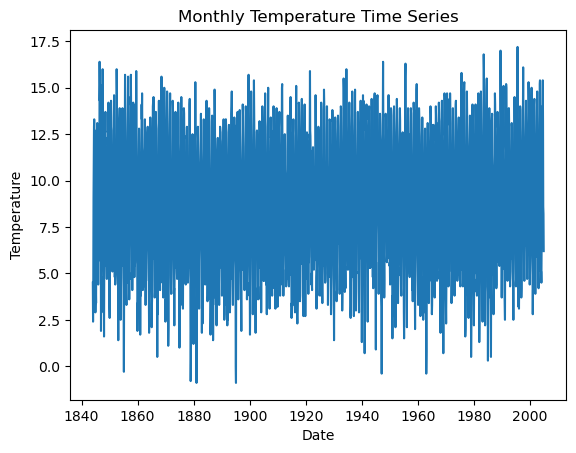

In [6]:
plt.plot(df_monthly['monthly'], df_monthly['x'])
plt.title('Monthly Temperature Time Series')
plt.xlabel('Date')
plt.ylabel('Temperature')
plt.show()

In [7]:
temp_by_season_month = df_monthly.groupby(['season', 'monthly'])['x'].mean().reset_index()

In [8]:
temp_by_season_month_pivot = temp_by_season_month.pivot(index='monthly', columns='season', values='x')

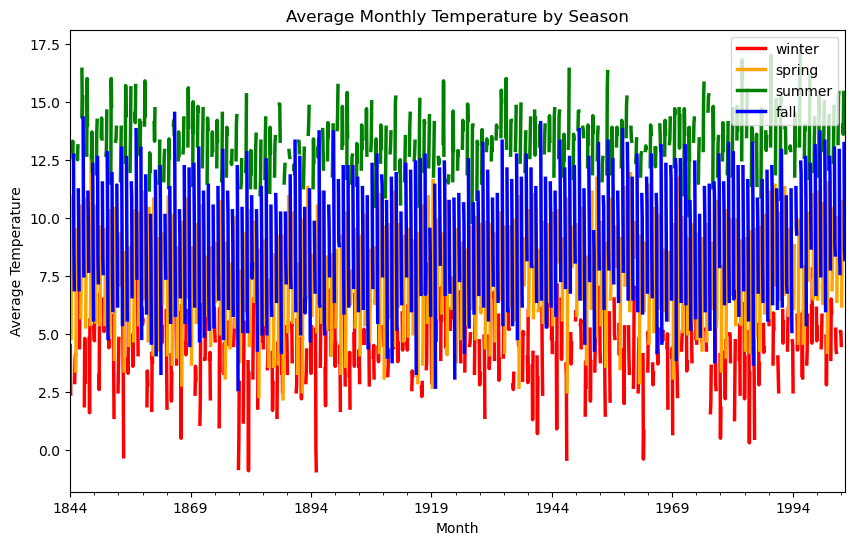

In [9]:
temp_by_season_month_pivot.plot(figsize=(10,6), linewidth=2.5, color=['red', 'orange', 'green', 'blue'])
plt.xlabel('Month')
plt.ylabel('Average Temperature')
plt.title('Average Monthly Temperature by Season')
plt.legend(loc='upper right')
plt.show()

In [10]:
df_monthly.drop(columns='season',inplace=True)
df_monthly.set_index('monthly',inplace=True)

In [11]:
print(df_monthly.head())
print(df_monthly.isnull().sum())

               x
monthly         
1844-01-01   4.5
1844-02-01   2.4
1844-03-01   4.8
1844-04-01   9.1
1844-05-01  10.9
x    0
dtype: int64


## No clear Idea about the data set so decreasing the size of window 

In [12]:
date_range_1 = pd.date_range(start='1960-01-01', end='2003-12-01', freq='MS')
df_monthly.loc[date_range_1].head(2)

,x
1960-01-01,4.0
1960-02-01,3.3


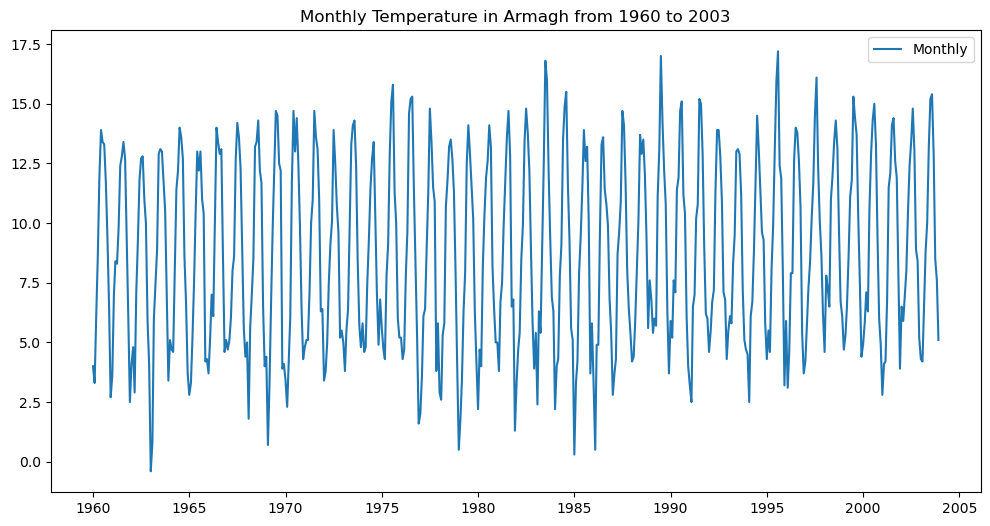

In [13]:
# Visualizing the monthly data
plt.figure(figsize=(12,6))
plt.plot(df_monthly.loc[date_range_1], label='Monthly')
plt.title('Monthly Temperature in Armagh from 1960 to 2003')
plt.legend(loc='best')
plt.show()

By looking to this data this is not showing any tredns also not staniory  and it could be a seasonal data 
for that we are futher moving on to 

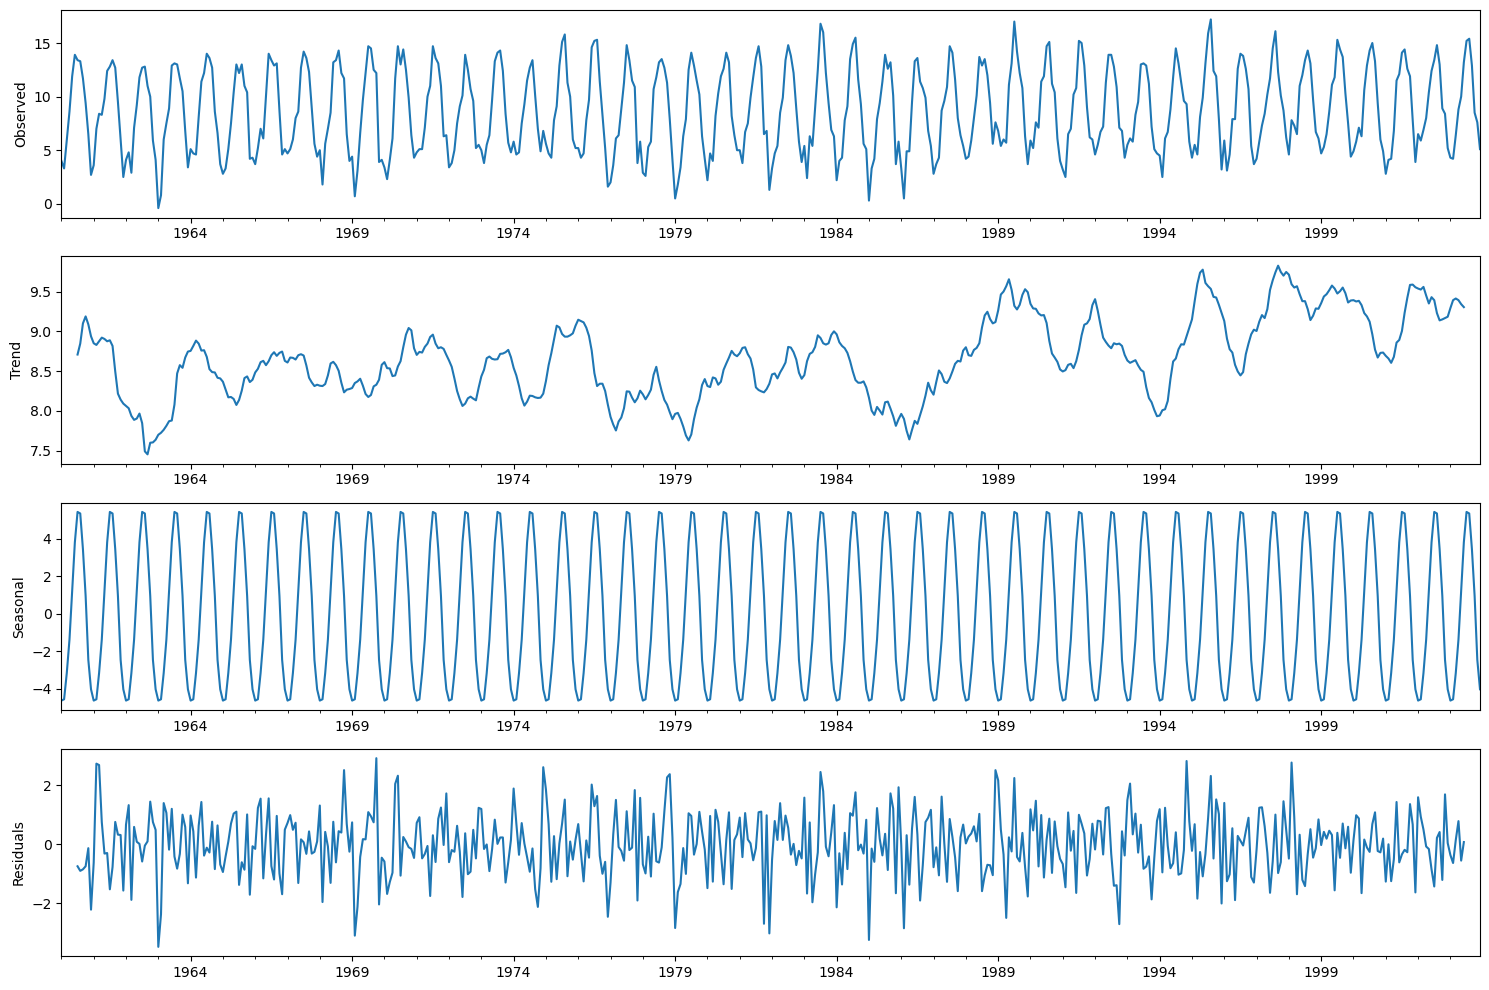

In [14]:
# Decomposing the monthly data to see trend, seasonality and residuals
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(df_monthly.loc[date_range_1], model='additive', period=12)
fig, (ax1,ax2,ax3,ax4) = plt.subplots(4,1,figsize=(15,10))
result.observed.plot(ax=ax1)
ax1.set_ylabel('Observed')
result.trend.plot(ax=ax2)
ax2.set_ylabel('Trend')
result.seasonal.plot(ax=ax3)
ax3.set_ylabel('Seasonal')
result.resid.plot(ax=ax4)
ax4.set_ylabel('Residuals')
plt.tight_layout()
plt.show()

### Model time 

If the seasonal plot appears to show a sine-like wave pattern, it suggests that the seasonal component of the time series exhibits a regular and consistent cyclical pattern over time. This may be due to natural seasonal cycles, such as the changing of the seasons or annual variations in economic activity, or it may be due to other recurring patterns in the data.

A sine-like wave pattern can be characterized by a consistent oscillation between positive and negative values over time, with a relatively consistent period (i.e., the length of time it takes for one complete cycle). If the amplitude (i.e., the magnitude of the peaks and valleys) of the wave is relatively constant over time, it suggests that the seasonal effects are relatively stable and can be modeled using a traditional seasonal time series method, such as seasonal ARIMA.

However, if the amplitude of the sine wave is changing over time, it suggests that the seasonal effects are not stable and may require a more flexible modeling approach, such as a state space model or dynamic regression. Additionally, if there are any irregularities or anomalies in the seasonal pattern, such as sudden spikes or dips in the amplitude, it may indicate the presence of unusual events or external factors that may need to be accounted for in the modeling process.

Overall, the seasonal plot can provide valuable insights into the underlying patterns and behavior of the time series, which can inform the selection and tuning of appropriate modeling methods.

In [15]:
#Splitting the data into train and test sets
train_monthly = df_monthly[:-12]
test_monthly = df_monthly[-12:]

In [16]:
from statsmodels.tsa.stattools import adfuller
def adf_test(series):
    result=adfuller(series)
    print('ADF Statistics: {}'.format(result[0]))
    print('p- value: {}'.format(result[1]))
    if result[1] <= 0.05:
        print("strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary")
    else:
        print("weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary ")

In [17]:
adf_test(df_monthly)

ADF Statistics: -5.000623974120458
p- value: 2.213013539022283e-05
strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary


## model 1 (naive)

In [18]:
# Create a forecast column in the test set that simply uses the previous value as the forecast
test_monthly['Naive forecast'] = test_monthly['x'].shift(1)

# Evaluate the forecast using a metric such as mean squared error (MSE)
mse = ((test_monthly['x'] - test_monthly['Naive forecast']) ** 2).mean()

# Print the MSE to see how well the naive model performed
print('Naive model MSE: ', mse)


Naive model MSE:  5.260909090909092


## Model -2 ( exponential Smoothing )

In [19]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing
#Exponential Smoothing
model_es_monthly = ExponentialSmoothing(train_monthly, seasonal_periods=12, trend='add', seasonal='add')
fit_es_monthly = model_es_monthly.fit()
pred_es_monthly = fit_es_monthly.forecast(steps=12)
print(fit_es_monthly.summary())
print('RMSE of Exponential Smoothing on monthly data:', np.sqrt(mean_squared_error(test_monthly['x'], pred_es_monthly)))

                       ExponentialSmoothing Model Results                       
Dep. Variable:                        x   No. Observations:                 1920
Model:             ExponentialSmoothing   SSE                           2803.730
Optimized:                         True   AIC                            758.961
Trend:                         Additive   BIC                            847.922
Seasonal:                      Additive   AICC                           759.321
Seasonal Periods:                    12   Date:                 Tue, 09 May 2023
Box-Cox:                          False   Time:                         10:54:56
Box-Cox Coeff.:                    None                                         
                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level               0.0245467                alpha                 True
smoothing_trend          

In [20]:
test_monthly['Exp.Smoothing pred'] = pred_es_monthly

### Model 3-Sarima 

### Checking the optimal value for Sarima 

In [21]:
from pmdarima.arima import auto_arima

# Use auto_arima to determine optimal (p,d,q) values
model_auto = auto_arima(train_monthly, seasonal=True, m=12, suppress_warnings=True)
print(model_auto.summary())

                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                 1920
Model:             SARIMAX(3, 1, 1)x(2, 0, 1, 12)   Log Likelihood               -3183.990
Date:                            Tue, 09 May 2023   AIC                           6385.980
Time:                                    11:08:57   BIC                           6436.016
Sample:                                01-01-1844   HQIC                          6404.390
                                     - 12-01-2003                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept  -1.298e-06   2.74e-05     -0.047      0.962   -5.51e-05    5.25e-05
ar.L1          0.2617      0.021   

In [22]:
#Forecasting for 12 months using the SARIMA model for monthly data
model_sarima_monthly = SARIMAX(train_monthly, order=(2,1,1), seasonal_order=(1,1,0,12))
fit_sarima_monthly = model_sarima_monthly.fit()
forecast_sarima_monthly = fit_sarima_monthly.forecast(steps=12)
print(fit_sarima_monthly.summary())



                                      SARIMAX Results                                      
Dep. Variable:                                   x   No. Observations:                 1920
Model:             SARIMAX(2, 1, 1)x(1, 1, [], 12)   Log Likelihood               -3399.678
Date:                             Tue, 09 May 2023   AIC                           6809.355
Time:                                     11:09:17   BIC                           6837.122
Sample:                                 01-01-1844   HQIC                          6819.575
                                      - 12-01-2003                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2013      0.022      9.307      0.000       0.159       0.244
ar.L2          0.0269      

In [23]:
# Calculate RMSE
rmse_sarima_monthly = np.sqrt(mean_squared_error(test_monthly['x'], forecast_sarima_monthly))
print('RMSE for SARIMA model:', rmse_sarima_monthly)

RMSE for SARIMA model: 0.5928339526690187


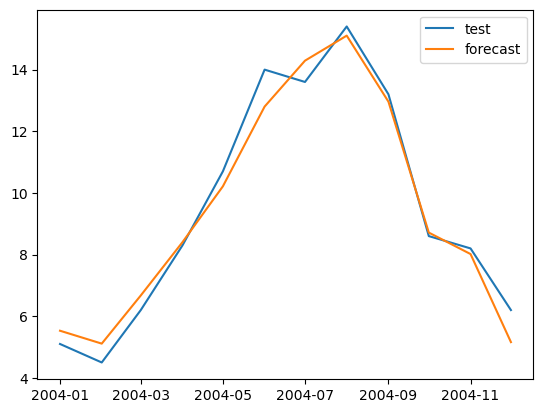

In [24]:

# Plot actual vs predicted values

plt.plot(test_monthly.index, test_monthly['x'], label='test')
plt.plot(forecast_sarima_monthly.index, forecast_sarima_monthly, label='forecast')
plt.legend()
plt.show()

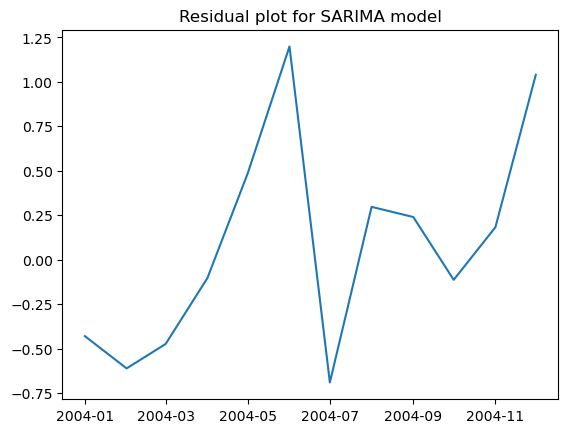

In [25]:

# Plot residuals
residuals_sarima_monthly = test_monthly['x'] - forecast_sarima_monthly
plt.plot(residuals_sarima_monthly)
plt.title('Residual plot for SARIMA model')
plt.show()


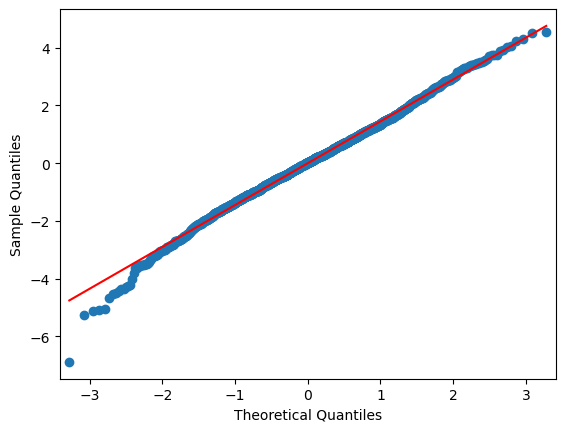

In [26]:
from statsmodels.graphics.gofplots import qqplot

# Generate QQ plot for residuals of SARIMA model
residuals = fit_sarima_monthly.resid
qqplot(residuals, line='s')
plt.show()


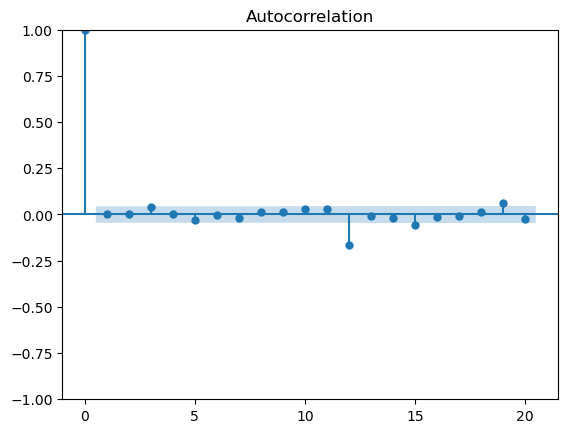

In [27]:
from statsmodels.graphics.tsaplots import plot_acf

# Generate autocorrelation plot for residuals of SARIMA model
plot_acf(residuals, lags=20)
plt.show()


### Forcasting all the results 

In [28]:
test_monthly['Sarima Forcast']=forecast_sarima_monthly
test_monthly

,x,Naive forecast,Exp.Smoothing pred,Sarima Forcast
monthly,,,,
2004-01-01,5.1,NaN,4.794754,5.530008
2004-02-01,4.5,5.1,4.987259,5.111439
2004-03-01,6.2,4.5,5.913504,6.673977
2004-04-01,8.3,6.2,7.907258,8.403770
2004-05-01,10.7,8.3,10.498506,10.214165
2004-06-01,14.0,10.7,13.187883,12.801148
2004-07-01,13.6,14.0,14.547880,14.290619
2004-08-01,15.4,13.6,14.509760,15.102995
2004-09-01,13.2,15.4,12.664759,12.960228


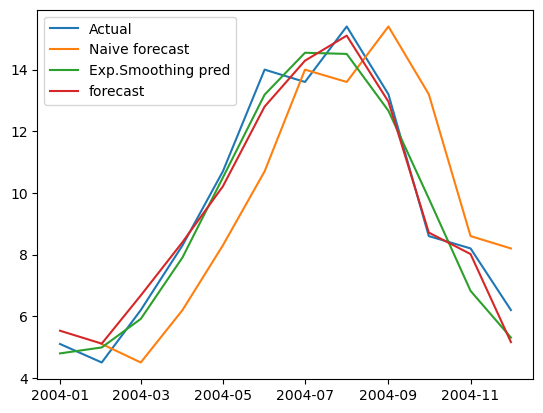

In [29]:
# Plot actual vs predicted values

plt.plot(test_monthly.index, test_monthly['x'], label='Actual')
plt.plot(test_monthly.index,test_monthly['Naive forecast'],label='Naive forecast')
plt.plot(test_monthly.index,test_monthly['Exp.Smoothing pred'],label='Exp.Smoothing pred')
plt.plot(forecast_sarima_monthly.index, forecast_sarima_monthly, label='forecast')
plt.legend()
plt.show()

### Yearly data set

In [30]:
df_yearly.shape

(161, 1)

In [31]:
date_range = pd.date_range(start='1844', end='2005', freq='Y')
df_yearly['date']=date_range

In [32]:
df_yearly.set_index('date',inplace=True)

In [33]:
df_yearly.tail()

,x
date,
2000-12-31,9.2
2001-12-31,8.8
2002-12-31,9.5
2003-12-31,9.3
2004-12-31,9.5


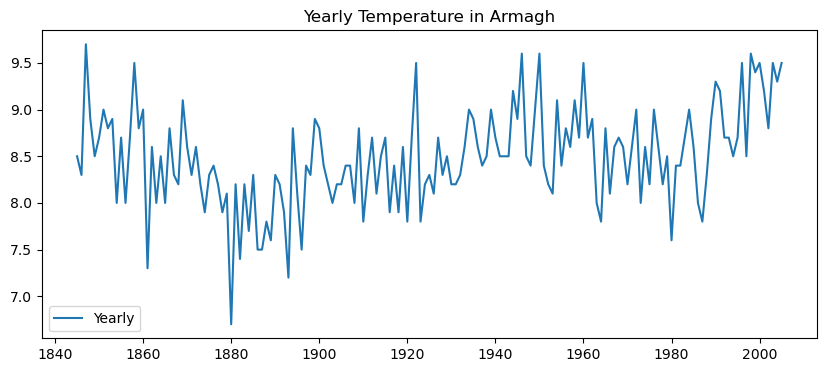

In [34]:
# Visualizing the yearly data
plt.figure(figsize=(10,4))
plt.plot(df_yearly, label='Yearly')
plt.title('Yearly Temperature in Armagh')
plt.legend(loc='best')
plt.show()

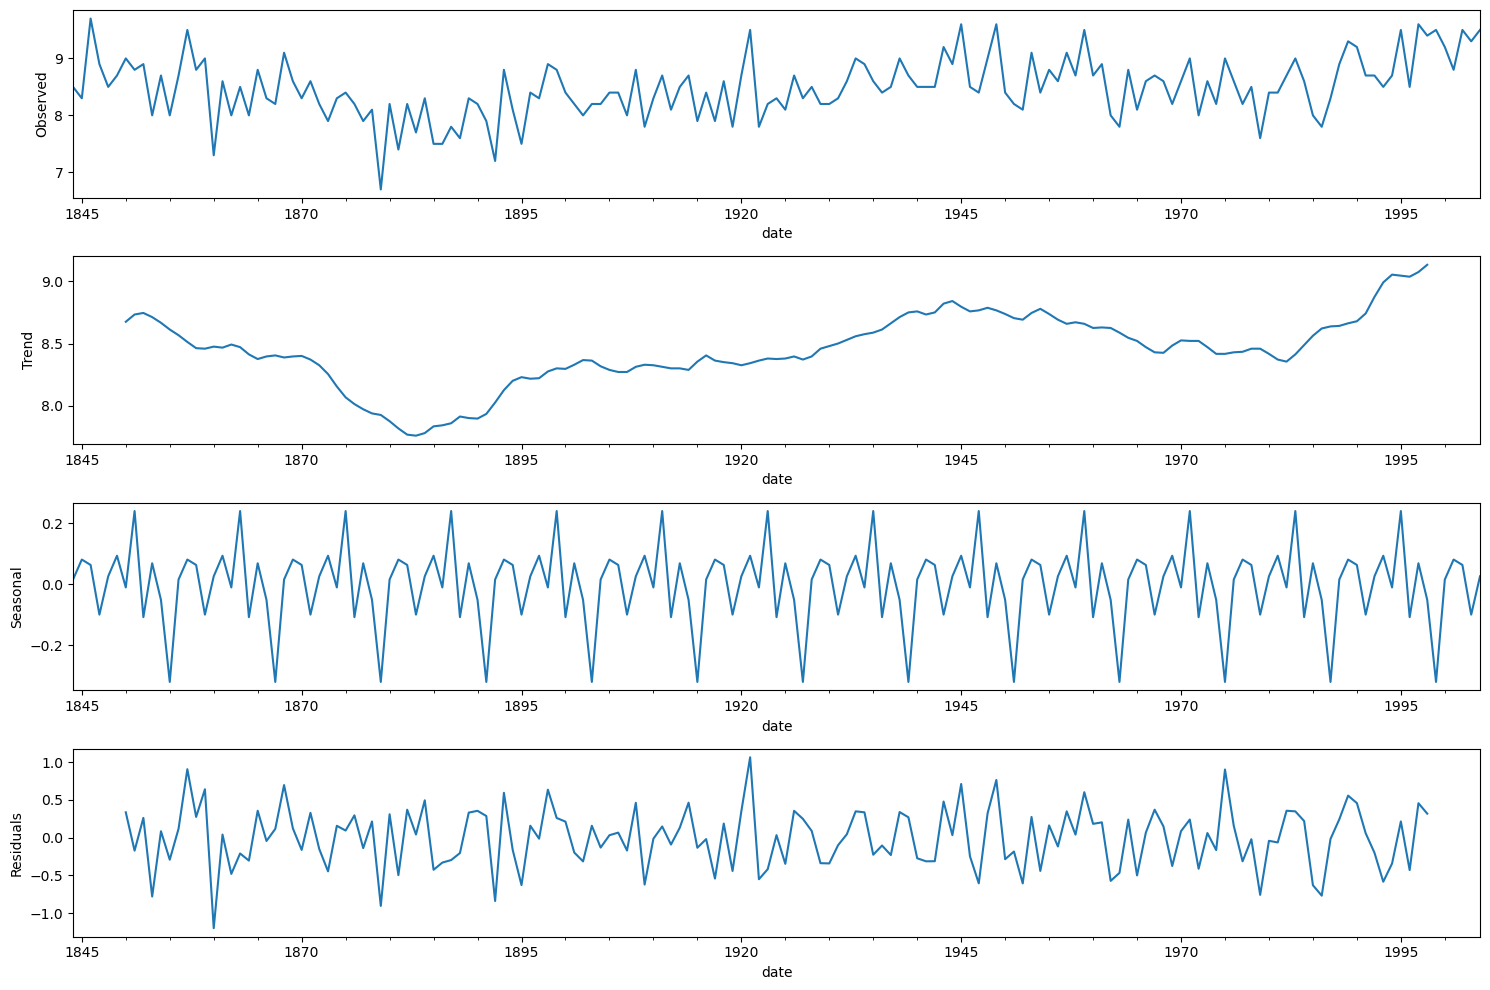

In [35]:
# Decomposing the monthly data to see trend, seasonality and residuals
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(df_yearly, model='additive', period=12)
fig, (ax1,ax2,ax3,ax4) = plt.subplots(4,1,figsize=(15,10))
result.observed.plot(ax=ax1)
ax1.set_ylabel('Observed')
result.trend.plot(ax=ax2)
ax2.set_ylabel('Trend')
result.seasonal.plot(ax=ax3)
ax3.set_ylabel('Seasonal')
result.resid.plot(ax=ax4)
ax4.set_ylabel('Residuals')
plt.tight_layout()
plt.show()

In [36]:
# Splitting the data into train and test sets
train_yearly = df_yearly[:-1]
test_yearly = df_yearly[-1:]

In [37]:
test_yearly

,x
date,
2004-12-31,9.5


## model 1 (naive)

In [38]:
# Create a forecast column in the test set that simply uses the previous value as the forecast
test_yearly['Naive forecast_y'] = test_yearly['x'].shift(1)

# Evaluate the forecast using a metric such as mean squared error (MSE)
mse = ((test_yearly['x'] - test_yearly['Naive forecast_y']) ** 2).mean()

# Print the MSE to see how well the naive model performed
print('Naive model MSE: ', mse)


Naive model MSE:  nan


### Model 2 Exponentials smoothing

In [39]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_squared_error
import numpy as np

# Define the model and fit it to the training data
model_es = ExponentialSmoothing(train_yearly, seasonal_periods=12, trend='add', seasonal='add')
fit_es = model_es.fit()

# Generate a one-step forecast
pred_es = fit_es.forecast(1)

# Calculate the root mean squared error (RMSE) of the forecast
mse = mean_squared_error(test_yearly['x'], pred_es)
rmse = np.sqrt(mse)

# Print a summary of the model and its performance
print(fit_es.summary())
print('RMSE: %.2f' % rmse)


                       ExponentialSmoothing Model Results                       
Dep. Variable:                        x   No. Observations:                  160
Model:             ExponentialSmoothing   SSE                             31.121
Optimized:                         True   AIC                           -229.966
Trend:                         Additive   BIC                           -180.763
Seasonal:                      Additive   AICC                          -225.115
Seasonal Periods:                    12   Date:                 Tue, 09 May 2023
Box-Cox:                          False   Time:                         11:09:21
Box-Cox Coeff.:                    None                                         
                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level               0.1759540                alpha                 True
smoothing_trend          

### 

## Model 3 Sarima A

In [40]:
from pmdarima.arima import auto_arima

# Use auto_arima to determine optimal (p,d,q) values
model_auto = auto_arima(train_yearly, seasonal=True, m=12, suppress_warnings=True)
print(model_auto.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  160
Model:               SARIMAX(0, 1, 1)   Log Likelihood                -103.463
Date:                Tue, 09 May 2023   AIC                            210.926
Time:                        11:09:27   BIC                            217.064
Sample:                    12-31-1844   HQIC                           213.419
                         - 12-31-2003                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.8274      0.052    -15.862      0.000      -0.930      -0.725
sigma2         0.2136      0.021     10.179      0.000       0.172       0.255
Ljung-Box (L1) (Q):                   0.17   Jarque-

In [46]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Create SARIMA model object and fit to data
model_ma = SARIMAX(train_yearly, order=(0, 1, 1), seasonal_order=(0, 0, 0, 0))
fit_ma = model_ma.fit()

# Generate forecast and calculate RMSE
pred_ma = fit_ma.forecast(steps=1)
rmse_ma = np.sqrt(mean_squared_error(test_yearly['x'], pred_ma))
print('RMSE for SARIMA on yearly data: {:.2f}'.format(rmse_ma))

# Print summary of fitted SARIMAXResults object
print(fit_ma.summary())


RMSE for SARIMA on yearly data: 0.35
                               SARIMAX Results                                
Dep. Variable:                      x   No. Observations:                  160
Model:               SARIMAX(0, 1, 1)   Log Likelihood                -103.463
Date:                Tue, 09 May 2023   AIC                            210.926
Time:                        11:18:40   BIC                            217.064
Sample:                    12-31-1844   HQIC                           213.419
                         - 12-31-2003                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.8274      0.052    -15.862      0.000      -0.930      -0.725
sigma2         0.2136      0.021     10.179      0.000       0.172       0.255
Ljung-Box (L1) 

In [50]:
test_yearly['Exponentials smoothing_yearly']=pred_es
test_yearly['Sarima_yearly']=pred_ma
test_yearly

,x,Naive forecast_y,Exponentials smoothing_yearly,Sarima_yearly
date,,,,
2004-12-31,9.5,NaN,9.18948,9.154547


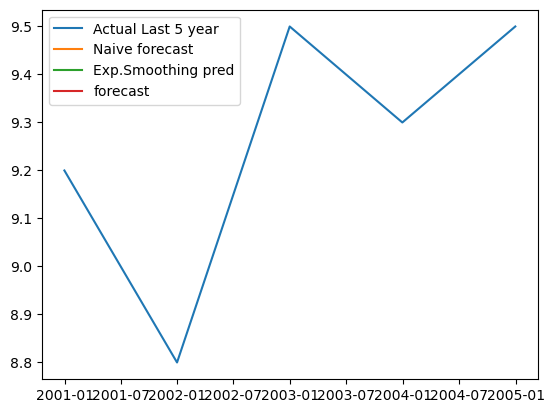

In [49]:
df_yearly[-5:]
plt.plot(df_yearly[-5:].index, df_yearly[-5:], label='Actual Last 5 year')
plt.plot(test_yearly.index,test_yearly['Naive forecast_y'],label='Naive forecast')
plt.plot(test_yearly.index,test_yearly['Exponentials smoothing_yearly'],label='Exp.Smoothing pred')
plt.plot(test_yearly.index, test_yearly['Sarima_yearly'], label='forecast')
plt.legend()
plt.show()

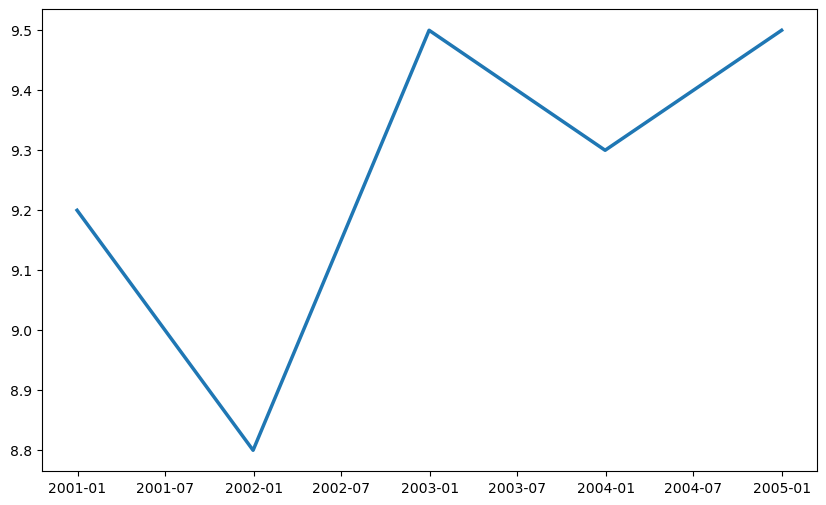

In [44]:
# Plot the actual values and the forecasts
plt.figure(figsize=(10, 6))
plt.plot(df_yearly[-5:].index, df_yearly[-5:], label='Actual Last 5 year', linewidth=2.5)
plt.plot(test_yearly.index, test_yearly['Naive forecast_y'], label='Naive forecast', linewidth=2.5)
plt.plot(test_yearly.index, test_yearly['Exponentials smoothing_yearly'], label='Exp.Smoothing pred', linewidth=2.5)
plt.plot(test_yearly.index, test_yearly['Sarima_yearly'], label='forecast', linewidth=2.5)